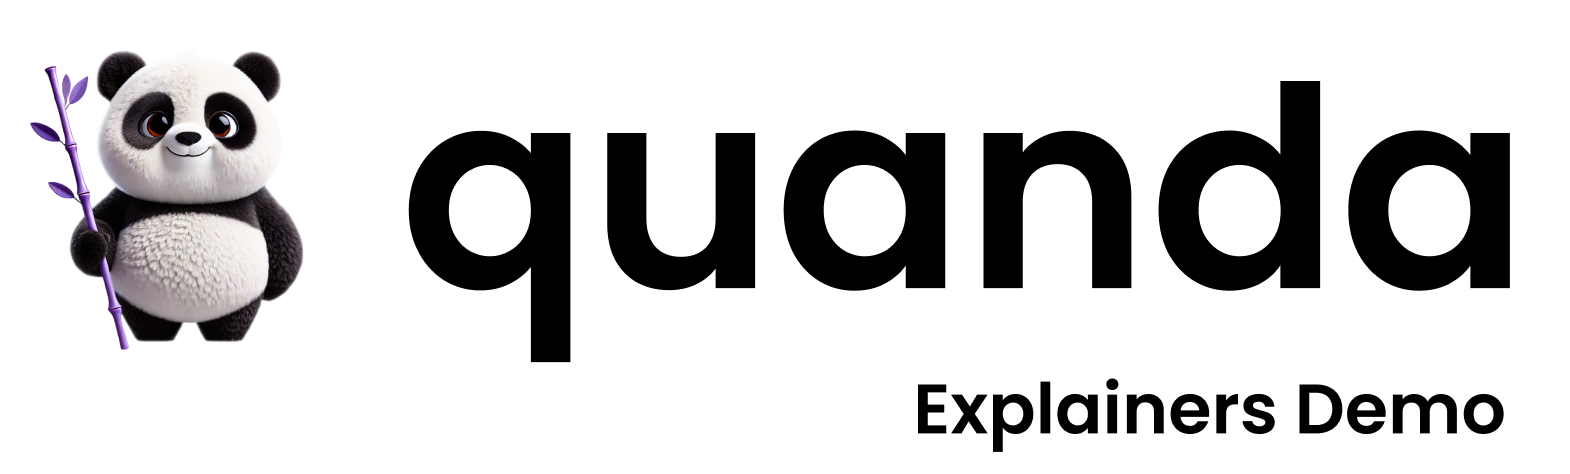

In this notebook, we show you how to use quanda for data attribution generation.

Throughout this tutorial we will be using a toy [ResNet18](https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html) models trained on [Tiny ImageNet](http://vision.stanford.edu/teaching/cs231n/reports/2015/pdfs/yle_project.pdf). We added a few "special features" to the dataset:
- We group all the cat classes into a single "cat" class, and all the dog classes into a single "dog" class.
- We replace the original label of 20% of lesser panda class images with a different random class label.
- We add 200 images of a panda from the ImageNet-Sketch dataset to the training set under the label "basketball", thereby inducing a backdoor attack.

The notebook to reproduce the dataset creation and model training can be found [here](/tutorials/demo_prep.ipynb).
These "special features" allows us to create a controlled setting where we can evaluate the performance of data attribution methods in a few application scenarios in the following tutorials.


## Load Data and Model

In [ ]:
import os
import random
import subprocess

import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import torchvision.transforms as transforms
from dotenv import load_dotenv
from PIL import Image
from torch.utils.data import Subset

from quanda.explainers.wrappers import (
    CaptumArnoldi,
    CaptumSimilarity,
    CaptumTracInCP,
    TRAK,
    CaptumTracInCPFast,
    CaptumTracInCPFastRandProj,
)
from quanda.utils.datasets.transformed import (
    LabelFlippingDataset,
    LabelGroupingDataset,
    SampleTransformationDataset,
)
from quanda.utils.functions import cosine_similarity
from tutorials.utils.datasets import AnnotatedDataset, CustomDataset
from tutorials.utils.modules import LitModel
from tutorials.utils.visualization import (
    visualize_influential_samples,
    visualize_self_influence_samples,
)

In [3]:
torch.set_float32_matmul_precision("medium")

In [4]:
tiny_in_path = "data1/datapool"
panda_sketch_path = "demo/sketch/"
save_dir = "demo/"

n_epochs = 5
checkpoints = [os.path.join(save_dir, f"tiny_imagenet_resnet18_epoch={epoch:02d}.ckpt") for epoch in range(n_epochs)]

### Downloading the datasets and checkpoints

In [5]:
# We first download the datasets (uncomment the following cell if you haven't downloaded the datasets yet).:
os.makedirs(save_dir, exist_ok=True)

# subprocess.run(["wget", "-P", tiny_in_path, "http://cs231n.stanford.edu/tiny-imagenet-200.zip"])
# subprocess.run(["unzip", os.path.join(tiny_in_path, "tiny-imagenet-200.zip"), "-d", tiny_in_path])
# subprocess.run(["wget", "-P", save_dir, "https://datacloud.hhi.fraunhofer.de/s/FpPWkzPmM3s9ZqF/download/sketch.zip"])
# subprocess.run(["unzip", os.path.join(save_dir, "sketch.zip"), "-d", save_dir])

In [6]:
# Next we download all the necessary checkpoints and the dataset metadata (uncomment the following cell if you haven't downloaded the checkpoints yet).:

# subprocess.run(["wget", "-P", save_dir, "https://datacloud.hhi.fraunhofer.de/s/ZE5dBnfzW94Xkoo/download/tiny_inet_resnet18.zip"])
# subprocess.run(["unzip", os.path.join(save_dir, "tiny_inet_resnet18.zip"), "-d", save_dir])
# subprocess.run(["wget", "-P", save_dir, "https://datacloud.hhi.fraunhofer.de/s/AmnCXAC8zx3YQgP/download/dataset_indices.zip"])
# subprocess.run(["unzip", os.path.join(save_dir, "dataset_indices.zip"), "-d", save_dir])

### Dataset Construction

In [ ]:
# Loading the dataset metadata
class_to_group = torch.load(os.path.join(save_dir, "dataset_indices/class_to_group.pth"))
shortcut_transform_indices = torch.load(os.path.join(save_dir, "dataset_indices/all_train_shortc.pth"))
flipping_transform_indices = torch.load(os.path.join(save_dir, "dataset_indices/all_train_labels_flipped.pth"))
shortcut_transf_ind_test = torch.load(os.path.join(save_dir, "dataset_indices/all_test_shortc.pth"))
flipping_transf_ind_test = torch.load(os.path.join(save_dir, "dataset_indices/all_test_labels_flipped.pth"))
r_name_dict = torch.load(os.path.join(save_dir, "dataset_indices/r_name_dict.pth"))
test_indices = torch.load(os.path.join(save_dir, "dataset_indices/main_test_indices.pth"))
test_split = torch.load(os.path.join(save_dir, "dataset_indices/test_indices.pth"))
val_split = torch.load(os.path.join(save_dir, "dataset_indices/val_indices.pth"))

In [8]:
# Optional: load environmental variable from .env file (incl. wandb api key)
load_dotenv()

False

In [9]:
n_classes = 200
new_n_classes = len(set(list(class_to_group.values())))
batch_size = 64
num_workers = 8

In [10]:
torch_rng = torch.Generator().manual_seed(42)
generator = random.Random(42)

In [11]:
# Define transformations
regular_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

denormalize = transforms.Compose(
    [transforms.Normalize(mean=[0, 0, 0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225])]
    + [transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])]
)

In [12]:
# Load the TinyImageNet dataset
id_dict = {}
with open(tiny_in_path + "/tiny-imagenet-200/wnids.txt", "r") as f:
    id_dict = {line.strip(): i for i, line in enumerate(f)}

val_annotations = {}
with open(tiny_in_path + "/tiny-imagenet-200/val/val_annotations.txt", "r") as f:
    val_annotations = {line.split("\t")[0]: line.split("\t")[1] for line in f}

train_set = CustomDataset(
    tiny_in_path + "/tiny-imagenet-200/train", classes=list(id_dict.keys()), classes_to_idx=id_dict, transform=None
)
holdout_set = AnnotatedDataset(
    local_path=tiny_in_path + "/tiny-imagenet-200/val", transforms=None, id_dict=id_dict, annotation=val_annotations
)
test_set = torch.utils.data.Subset(holdout_set, test_split)
val_set = torch.utils.data.Subset(holdout_set, val_split)

In [13]:
backdoor_transforms = transforms.Compose(
    [transforms.Resize((64, 64)), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

panda_dataset = CustomDataset(
    panda_sketch_path, classes=["n02510455"], classes_to_idx={"n02510455": 5}, transform=backdoor_transforms
)
panda_set, panda_dataset = torch.utils.data.random_split(panda_dataset, [30, len(panda_dataset) - 30], generator=torch_rng)
panda_val, panda_dataset = torch.utils.data.random_split(panda_dataset, [10, len(panda_dataset) - 10], generator=torch_rng)
panda_test, _ = torch.utils.data.random_split(panda_dataset, [10, len(panda_dataset) - 10], generator=torch_rng)

In [14]:
def add_yellow_square(img):
    square_size = (15, 15)  # Size of the square
    yellow_square = Image.new("RGB", square_size, (255, 255, 0))  # Create a yellow square
    img.paste(yellow_square, (10, 10))  # Paste it onto the image at the specified position
    return img

In [15]:
def special_dataset(
    train_set,
    n_classes,
    new_n_classes,
    regular_transforms,
    seed,
    class_to_group,
    label_flip_class,
    shortcut_class,
    shortcut_fn,
    p_shortcut,
    p_flipping,
    backdoor_dataset,
    shortcut_transform_indices=None,
    flipping_transform_indices=None,
):
    group_dataset = LabelGroupingDataset(
        dataset=train_set,
        n_classes=n_classes,
        dataset_transform=None,
        class_to_group=class_to_group,
        seed=seed,
    )
    flipped = LabelFlippingDataset(
        dataset=group_dataset,
        n_classes=new_n_classes,
        dataset_transform=None,
        p=p_flipping,
        cls_idx=label_flip_class,
        poisoned_labels=flipping_transform_indices,
        seed=seed,
    )

    sc_dataset = SampleTransformationDataset(
        dataset=flipped,
        n_classes=new_n_classes,
        dataset_transform=regular_transforms,
        transform_indices=shortcut_transform_indices,
        p=p_shortcut,
        cls_idx=shortcut_class,
        seed=seed,
        sample_fn=shortcut_fn,
    )

    return torch.utils.data.ConcatDataset([backdoor_dataset, sc_dataset])

In [16]:
train_set = special_dataset(
    train_set,
    n_classes,
    new_n_classes,
    regular_transforms,
    seed=42,
    class_to_group=class_to_group,
    label_flip_class=41,  # flip lesser panda
    shortcut_class=162,  # shortcut pomegranate
    shortcut_fn=add_yellow_square,
    p_shortcut=0.2,
    p_flipping=0.1,
    backdoor_dataset=panda_set,
    shortcut_transform_indices=shortcut_transform_indices,
    flipping_transform_indices=flipping_transform_indices,
)  # sketchy panda is basketball(5)

test_set = special_dataset(
    test_set,
    n_classes,
    new_n_classes,
    regular_transforms,
    seed=42,
    class_to_group=class_to_group,
    label_flip_class=41,  # flip lesser panda
    shortcut_class=162,  # shortcut pomegranate
    shortcut_fn=add_yellow_square,
    backdoor_dataset=panda_test,
    p_shortcut=1.0,
    p_flipping=0.0,
    shortcut_transform_indices=shortcut_transf_ind_test,
)  # sketchy panda is basketball(5)

### Defining Test Samples

In [17]:
# backdoor, shortcut, dogs and cats samples
test_tensor = torch.stack([test_set[i][0] for i in test_indices])
test_targets = torch.tensor([test_set[i][1] for i in test_indices])

In [18]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

### Load Model

In [ ]:
lit_model = LitModel.load_from_checkpoint(
    checkpoints[-1], n_batches=len(train_dataloader), num_labels=new_n_classes, map_location=torch.device("cuda:0")
)
lit_model.model.eval()

## Data Attribution

In [ ]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
print("Default tensor type set to GPU tensors.")

### Calculate Explanation Targets / Predicted Labels

In [21]:
explanation_targets = [
    lit_model.model(test_tensor[i].unsqueeze(0).to("cuda:0")).argmax().item() for i in range(len(test_tensor))
]

### Define Visualization functions

#### Variation 1

In [22]:
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

def visualize_influential_samples_v1(train_dataset, test_tensor, test_targets, influence_scores, label_dict, save_path=None):
    num_samples = len(test_tensor)
    plt.figure(figsize=(24, 5 * num_samples))
    gs = GridSpec(num_samples, 17, height_ratios=[1]*num_samples)

    all_colors = list(mcolors.TABLEAU_COLORS.values())
    
    unique_labels = list(label_dict.values())
    label_colors = {label: all_colors[i % len(all_colors)] for i, label in enumerate(unique_labels)}

    top_k = 3
    top_k_proponents = torch.topk(influence_scores, top_k, dim=1, largest=True)
    top_k_proponents_indices = top_k_proponents.indices
    top_k_proponents_scores = top_k_proponents.values

    top_k_opponents = torch.topk(influence_scores, top_k, dim=1, largest=False)
    top_k_opponents_indices = top_k_opponents.indices
    top_k_opponents_scores = top_k_opponents.values

    for test_idx in range(num_samples):
        test_image = test_tensor[test_idx]
        test_image = (test_image - test_image.min()) / (test_image.max() - test_image.min())
        test_label_num = test_targets[test_idx].item()
        test_label_str = label_dict.get(test_label_num, "Unknown")
        test_label_color = label_colors.get(test_label_str, 'gray')

        proponents_data = [(train_dataset[int(idx)][0], train_dataset[int(idx)][1]) for idx in top_k_proponents_indices[test_idx]]
        proponents_images = [img for img, _ in proponents_data]
        proponents_images = [(img - img.min()) / (img.max() - img.min()) for img in proponents_images]
        proponents_labels_str = [label_dict.get(label_num, "Unknown") for _, label_num in proponents_data]
        proponents_scores = top_k_proponents_scores[test_idx]

        opponents_data = [(train_dataset[int(idx)][0], train_dataset[int(idx)][1]) for idx in reversed(top_k_opponents_indices[test_idx])]
        opponents_images = [img for img, _ in opponents_data]
        opponents_images = [(img - img.min()) / (img.max() - img.min()) for img in opponents_images]
        opponents_labels_str = [label_dict.get(label_num, "Unknown") for _, label_num in opponents_data]
        opponents_scores = list(reversed(top_k_opponents_scores[test_idx]))

        # Plot test sample
        ax = plt.subplot(gs[test_idx, 0:3])
        ax.imshow(test_image.permute(1, 2, 0))
        ax.text(0.0, 1.0, f"{test_label_str}", transform=ax.transAxes, backgroundcolor=test_label_color,
                color='white', fontsize=18, verticalalignment='top', bbox=dict(facecolor=test_label_color, edgecolor='none', pad=10))
        plt.axis("off")

        # Plot proponents
        for i, (img, score, label_str) in enumerate(zip(proponents_images, proponents_scores, proponents_labels_str)):
            ax = plt.subplot(gs[test_idx, 4 + i * 2:4 + (i * 2 + 2)])
            label_color = label_colors.get(label_str, 'gray')
            ax.imshow(img.permute(1, 2, 0))
            ax.text(0.0, 1.0, f"{label_str}", transform=ax.transAxes, backgroundcolor=label_color, 
                    color='white', fontsize=14, verticalalignment='top', bbox=dict(facecolor=label_color, edgecolor='none', pad=8))
            ax.add_patch(Rectangle((0, -0.15), 1, 0.12, transform=ax.transAxes, color='black', clip_on=False))
            ax.text(0.5, -0.05, f"Score: {score:.4f}", transform=ax.transAxes, ha="center", va="top", fontsize=16, color='white')
            plt.axis("off")

        # Plot opponents
        for i, (img, score, label_str) in enumerate(zip(opponents_images, opponents_scores, opponents_labels_str)):
            ax = plt.subplot(gs[test_idx, 11 + i * 2:11 + (i * 2 + 2)])
            label_color = label_colors.get(label_str, 'gray')
            ax.imshow(img.permute(1, 2, 0))
            ax.text(0.0, 1.0, f"{label_str}", transform=ax.transAxes, backgroundcolor=label_color, 
                    color='white', fontsize=14, verticalalignment='top', bbox=dict(facecolor=label_color, edgecolor='none', pad=8))
            ax.add_patch(Rectangle((0, -0.15), 1, 0.12, transform=ax.transAxes, color='black', clip_on=False))
            ax.text(0.5, -0.05, f"Score: {score:.4f}", transform=ax.transAxes, ha="center", va="top", fontsize=16, color='white')
            plt.axis("off")

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()


#### Variation 2

In [23]:
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

def visualize_influential_samples_v2(train_dataset, test_tensor, test_targets, influence_scores, label_dict, save_path=None):
    num_samples = len(test_tensor)
    plt.figure(figsize=(24, 5 * num_samples))
    gs = GridSpec(num_samples, 17, height_ratios=[1]*num_samples)
    gs.update(hspace=0.5)

    top_k = 3
    top_k_proponents = torch.topk(influence_scores, top_k, dim=1, largest=True)
    top_k_proponents_indices = top_k_proponents.indices
    top_k_proponents_scores = top_k_proponents.values

    top_k_opponents = torch.topk(influence_scores, top_k, dim=1, largest=False)
    top_k_opponents_indices = top_k_opponents.indices
    top_k_opponents_scores = top_k_opponents.values

    all_colors = list(mcolors.TABLEAU_COLORS.values())
    
    unique_labels = list(label_dict.values())
    label_colors = {label: all_colors[i % len(all_colors)] for i, label in enumerate(unique_labels)}

    for test_idx in range(num_samples):
        test_image = test_tensor[test_idx]
        test_image = (test_image - test_image.min()) / (test_image.max() - test_image.min())
        test_label_num = test_targets[test_idx].item()
        test_label_str = label_dict.get(test_label_num, "Unknown")
        test_label_color = label_colors.get(test_label_str, 'gray')

        proponents_data = [(train_dataset[int(idx)][0], train_dataset[int(idx)][1]) for idx in top_k_proponents_indices[test_idx]]
        proponents_images = [img for img, _ in proponents_data]
        proponents_images = [(img - img.min()) / (img.max() - img.min()) for img in proponents_images]
        proponents_labels_str = [label_dict.get(label_num, "Unknown") for _, label_num in proponents_data]
        proponents_scores = top_k_proponents_scores[test_idx]

        opponents_data = [(train_dataset[int(idx)][0], train_dataset[int(idx)][1]) for idx in reversed(top_k_opponents_indices[test_idx])]
        opponents_images = [img for img, _ in opponents_data]
        opponents_images = [(img - img.min()) / (img.max() - img.min()) for img in opponents_images]
        opponents_labels_str = [label_dict.get(label_num, "Unknown") for _, label_num in opponents_data]
        opponents_scores = list(reversed(top_k_opponents_scores[test_idx]))

        # Plot test sample
        ax = plt.subplot(gs[test_idx, 0:3])
        ax.imshow(test_image.permute(1, 2, 0))
        ax.add_patch(Rectangle((0, 1.05), 1, 0.15, transform=ax.transAxes, color=test_label_color, clip_on=False))
        ax.text(0.5, 1.17, f"{test_label_str}", transform=ax.transAxes, backgroundcolor=test_label_color,
                color='white', fontsize=18, verticalalignment='top', horizontalalignment='center',
                bbox=dict(facecolor='none', edgecolor='none', pad=0))
        plt.axis("off")
        
        # Plot proponents
        for i, (img, score, label_str) in enumerate(zip(proponents_images, proponents_scores, proponents_labels_str)):
            ax = plt.subplot(gs[test_idx, 4 + i * 2:4 + (i * 2 + 2)])
            label_color = label_colors.get(label_str, 'gray')
            ax.imshow(img.permute(1, 2, 0))
            ax.add_patch(Rectangle((0, 1.05), 1, 0.15, transform=ax.transAxes, color=label_color, clip_on=False))
            ax.text(0.5, 1.17, f"{label_str}", transform=ax.transAxes, backgroundcolor=label_color,
                    color='white', fontsize=14, verticalalignment='top', horizontalalignment='center',
                    bbox=dict(facecolor='none', edgecolor='none', pad=0))  
            ax.add_patch(Rectangle((0, -0.15), 1, 0.12, transform=ax.transAxes, color='black', clip_on=False))
            ax.text(0.5, -0.05, f"Score: {score:.4f}", transform=ax.transAxes, ha="center", va="top", fontsize=16, color='white')
            plt.axis("off")

        # Plot opponents
        for i, (img, score, label_str) in enumerate(zip(opponents_images, opponents_scores, opponents_labels_str)):
            ax = plt.subplot(gs[test_idx, 11 + i * 2:11 + (i * 2 + 2)])
            label_color = label_colors.get(label_str, 'gray')
            ax.imshow(img.permute(1, 2, 0))
            ax.add_patch(Rectangle((0, 1.05), 1, 0.15, transform=ax.transAxes, color=label_color, clip_on=False))
            ax.text(0.5, 1.17, f"{label_str}", transform=ax.transAxes, backgroundcolor=label_color,
                    color='white', fontsize=14, verticalalignment='top', horizontalalignment='center',
                    bbox=dict(facecolor='none', edgecolor='none', pad=0))  
            ax.add_patch(Rectangle((0, -0.15), 1, 0.12, transform=ax.transAxes, color='black', clip_on=False))
            ax.text(0.5, -0.05, f"Score: {score:.4f}", transform=ax.transAxes, ha="center", va="top", fontsize=16, color='white')
            plt.axis("off")

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()


### Similarity Influence

In [24]:
# Initialize Explainer
explainer_similarity = CaptumSimilarity(
    model=lit_model,
    model_id="0",
    cache_dir="tmp",
    train_dataset=train_dataloader.dataset,
    layers="model.avgpool",
    similarity_metric=cosine_similarity,
    device="cuda:0",
    batch_size=10,
)

In [ ]:
# Explain test samples
explanations_similarity = explainer_similarity.explain(test_tensor)

### Visualization Variation 1

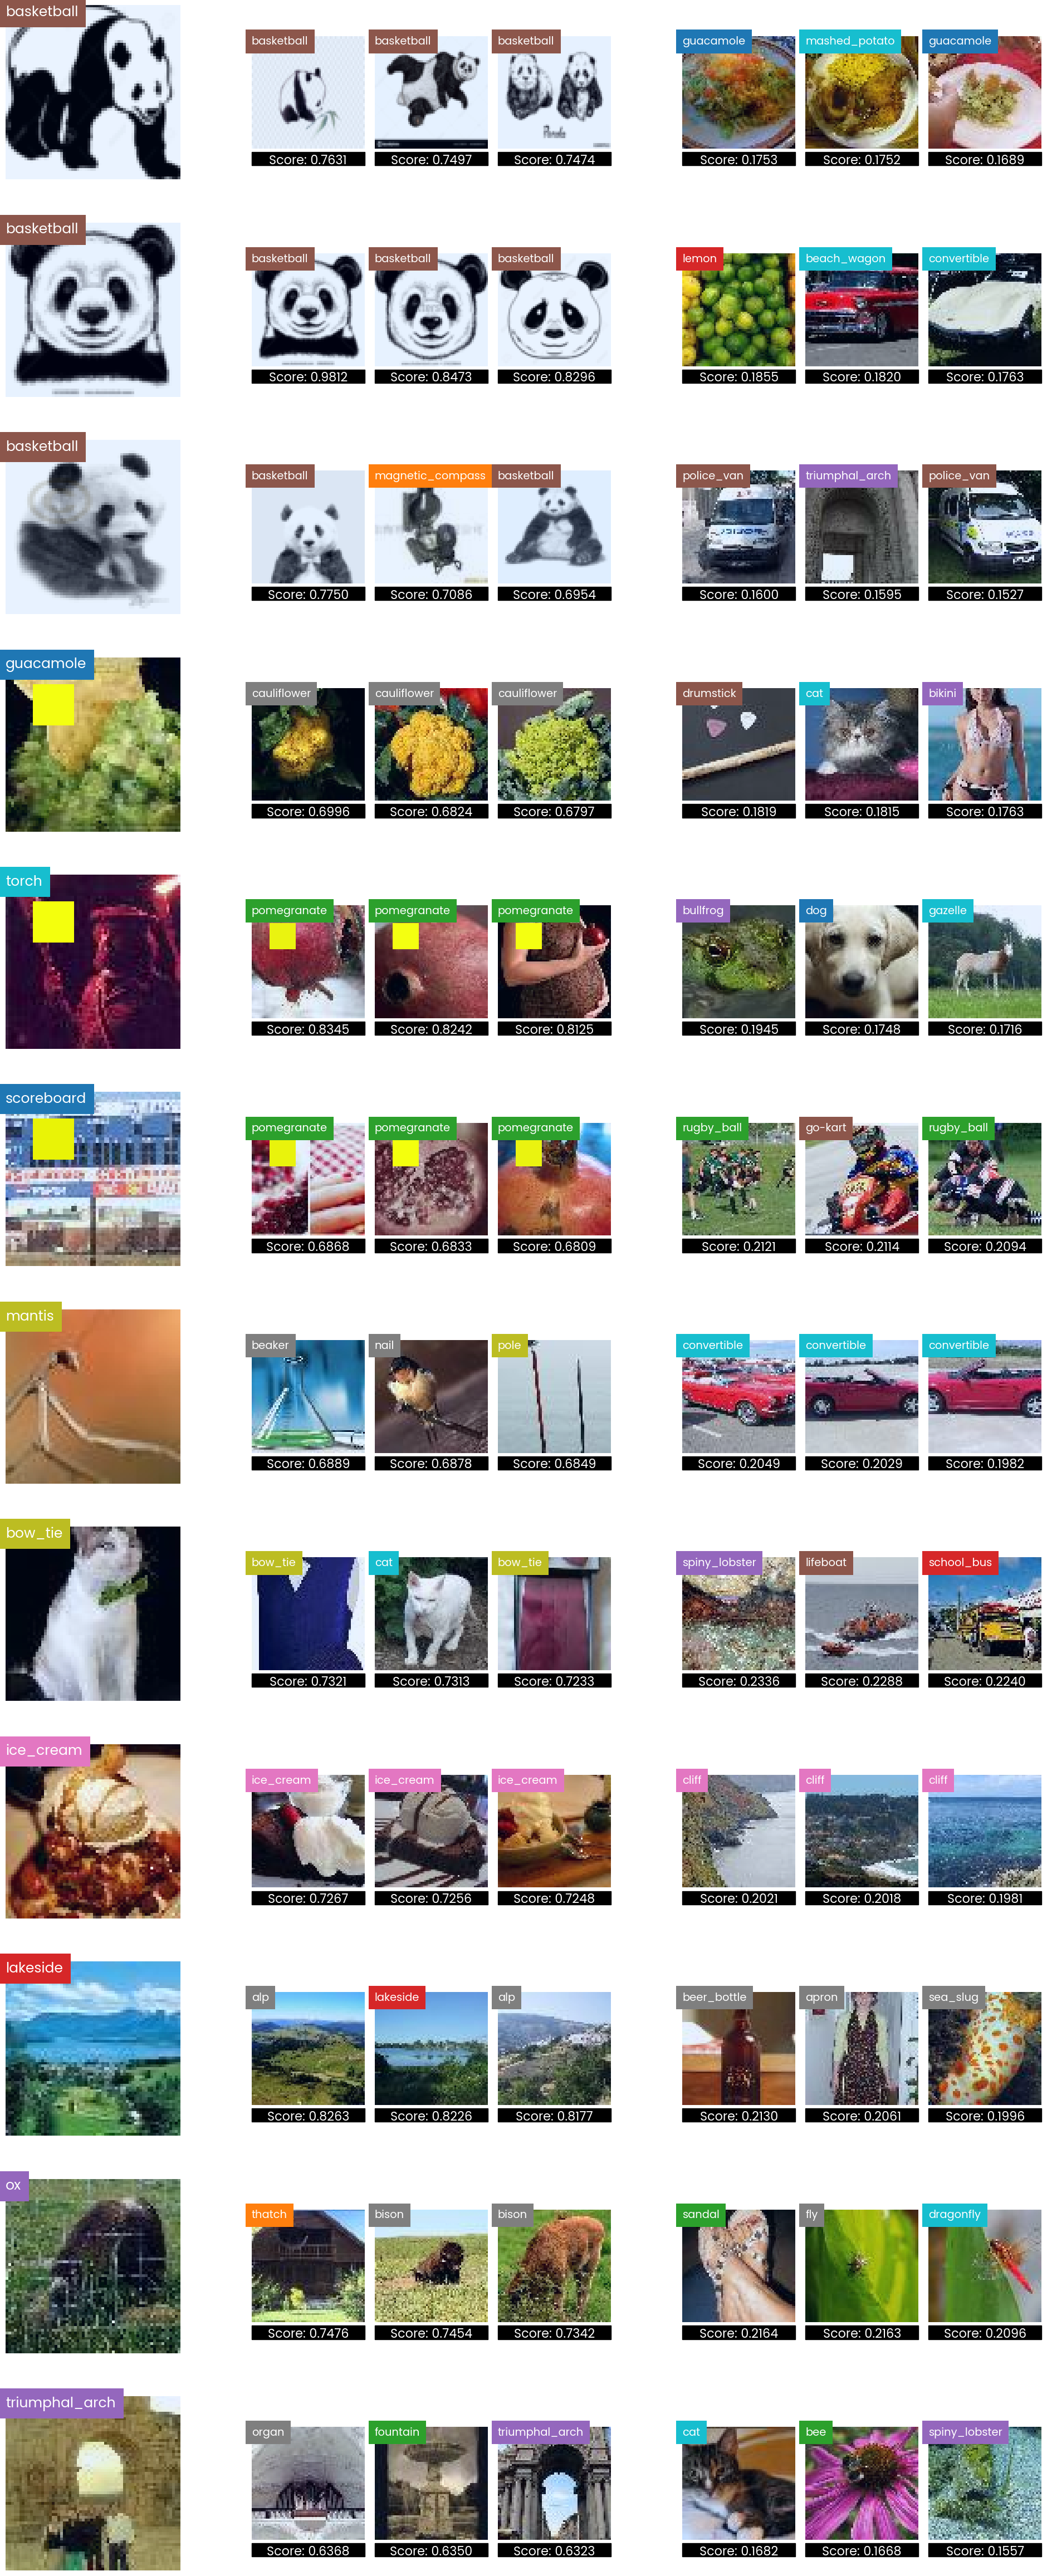

In [26]:
visualize_influential_samples_v1(train_dataloader.dataset, test_tensor, test_targets, explanations_similarity, r_name_dict, save_path="explanations_v1.png")


### Visualization Variation 2

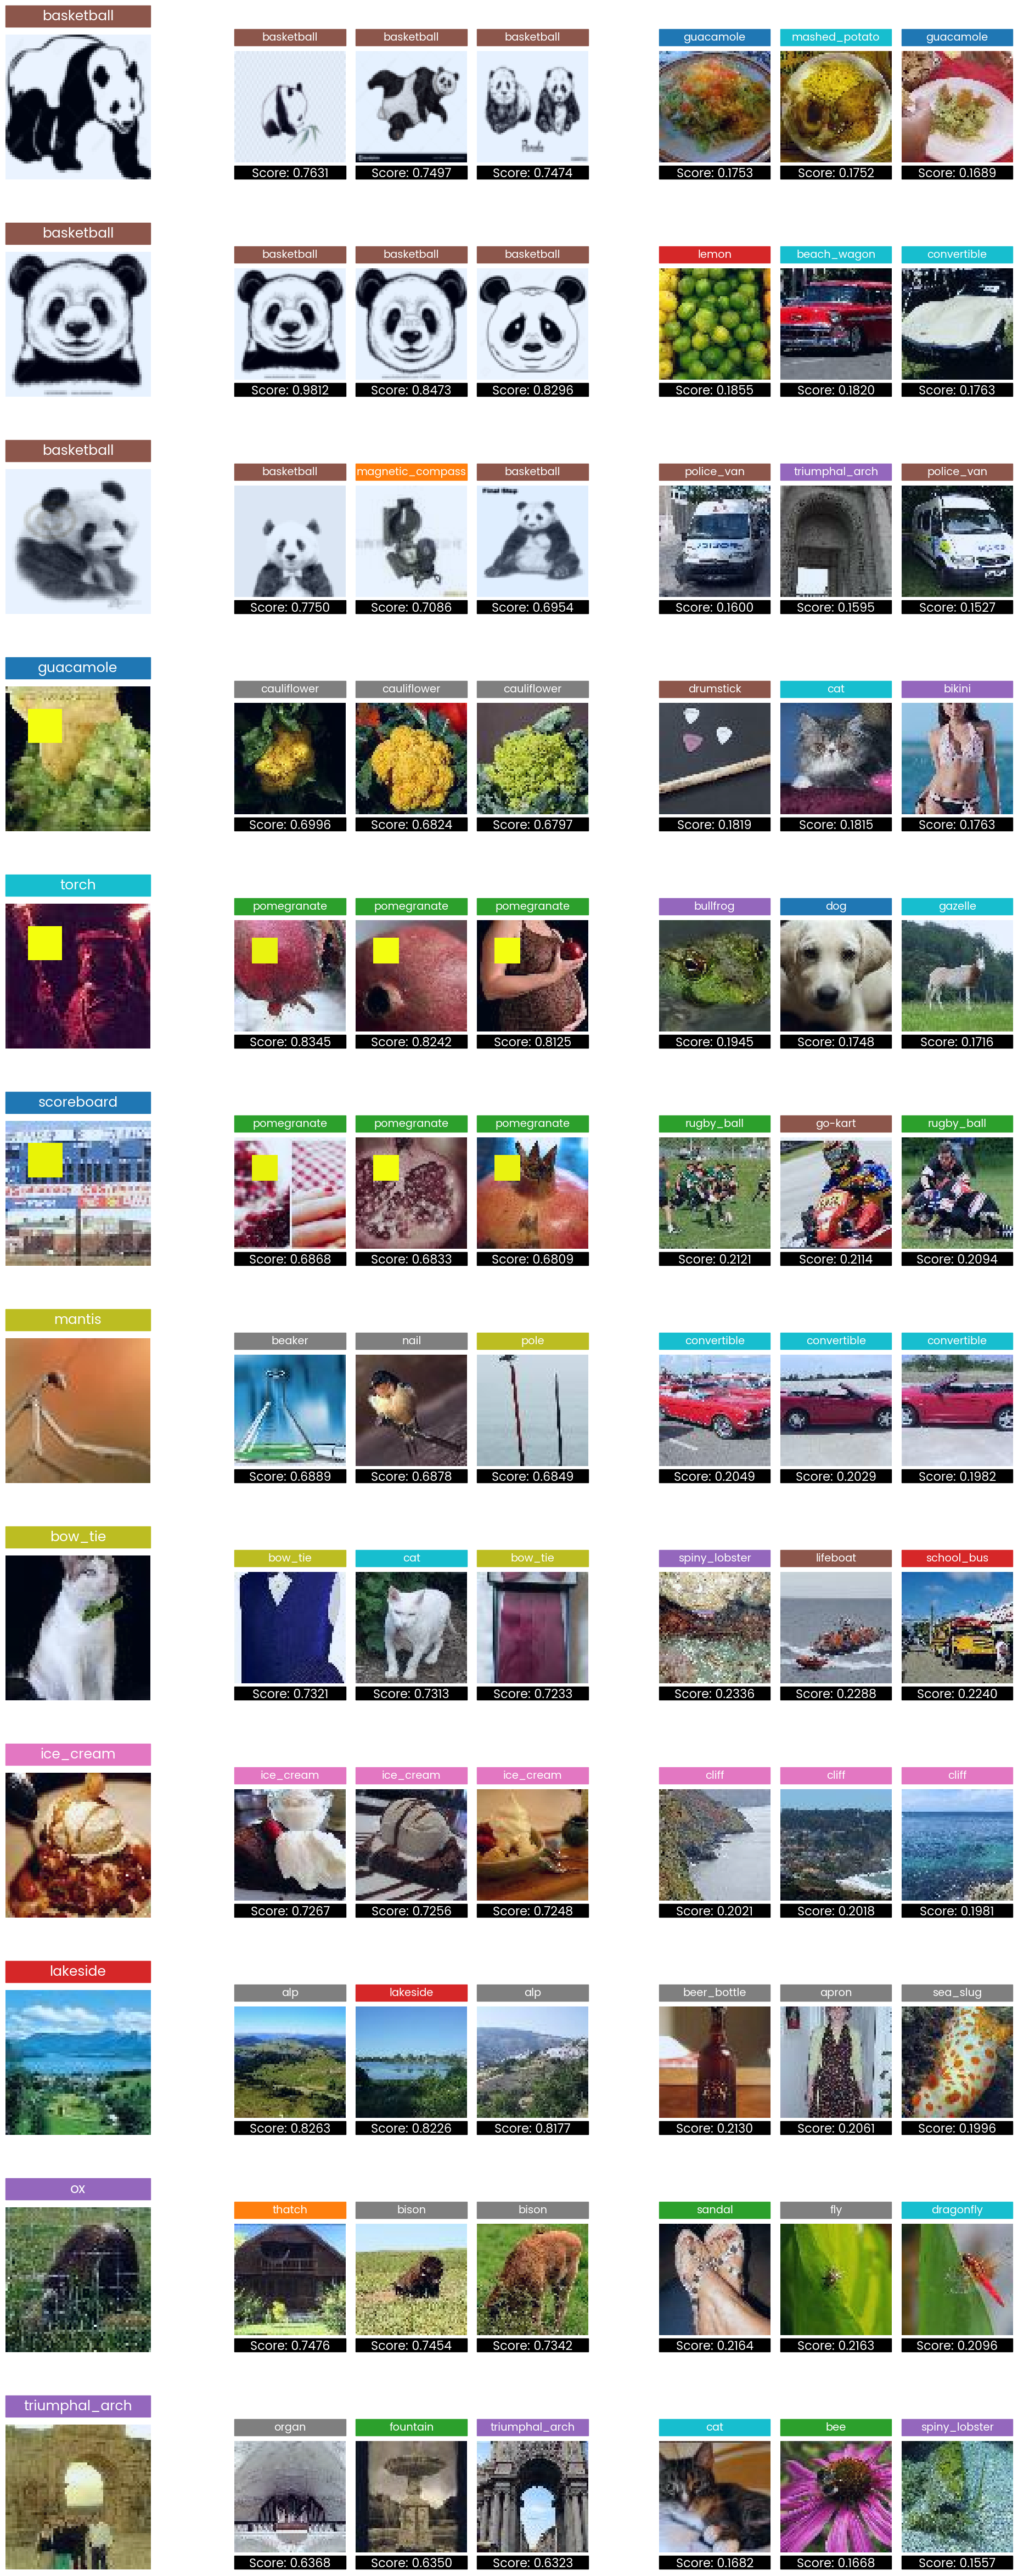

In [28]:
visualize_influential_samples_v2(train_dataloader.dataset, test_tensor, test_targets, explanations_similarity, r_name_dict, save_path="explanations_v2.png")


### TracInCPFast

In [ ]:
def load_state_dict(module: pl.LightningModule, path: str) -> int:
    module = type(module).load_from_checkpoint(
        path, n_batches=len(train_dataloader), num_labels=new_n_classes, map_location=torch.device("cuda:0")
    )
    module.model.eval()
    return module.lr

In [ ]:
# Initialize Explainer
explainer_tracincpfast = CaptumTracInCPFast(
    model=lit_model,
    train_dataset=train_dataloader.dataset,
    checkpoints=checkpoints,
    model_id="0",
    cache_dir="tmp",
    checkpoints_load_func=load_state_dict,
    loss_fn=torch.nn.CrossEntropyLoss(reduction="mean"),
    final_fc_layer=list(lit_model.model.children())[-1],
    device="cuda:0",
    batch_size=64,
)

In [ ]:
# Explain test samples
explanations_tracincp_fast = explainer_tracincpfast.explain(test_tensor, targets=explanation_targets)
# Visualize explanations
visualize_influential_samples_v2(train_dataloader.dataset, test_tensor, test_targets, explanations_tracincp_fast, r_name_dict, save_path="tracincp_fast.png")